In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV

from tqdm import tqdm
from joblib import delayed, Parallel

import logging
import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from learning.utils.load_experiment import LoadExperiment
from learning.policy_pricer import policy_pricer_python
from learning.policy_pricer.cython_pricer import cython_pricer_optimized

[INFO] [2021-04-17 00:36:46,098] [tensorflow] - Enabling eager execution
[INFO] [2021-04-17 00:36:46,101] [tensorflow] - Enabling v2 tensorshape
[INFO] [2021-04-17 00:36:46,101] [tensorflow] - Enabling resource variables
[INFO] [2021-04-17 00:36:46,102] [tensorflow] - Enabling tensor equality
[INFO] [2021-04-17 00:36:46,103] [tensorflow] - Enabling control flow v2


List regularized models:

In [2]:
ldr = LoadExperiment(backup=False)
agents = os.listdir(os.path.join(ldr.repo, 'models'))
agents

['BSpline-0',
 'BSpline-1',
 'BSpline-2',
 'BSplineConstr-0',
 'BSplineConstr-1',
 'BSplineConstr-2',
 'DQN-0',
 'DQN-1',
 'DQN-2',
 'DQNL1-0',
 'DQNL1-1',
 'DQNL1-2']

Test loading of an agent:

In [3]:
cps = ldr.list_checkpoints(agents[-1], -1)
ag = ldr.load_agent_from_path(cps[5])
ag.main_net.summary()

[WARNING] [2021-04-17 00:36:46,692] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 33,795
Trainable params: 33,795
Non-trainable params: 0
_________________________________________________________________


Let's setup an evaluation portfolio, i.e., starting positions, and precompute portfolio aav and optimal value under sustained policy, in the sense of MS control paper

In [4]:
SEED = 1
np.random.seed(SEED)

n_acc = 100
llb = 0.2
lub = 1.2
wlb = 50.
wub = 200.

portfolio = np.array([[np.random.uniform(llb, lub), np.random.uniform(wlb, wub)] for _ in range(n_acc)])

Text(0.5, 1.0, 'portfolio')

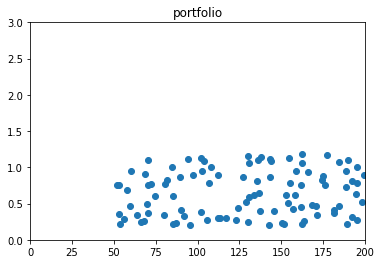

In [5]:
fig, ax = plt.subplots()
ax.scatter(portfolio[:, 1], portfolio[:, 0])
ax.set_ylim([0, 3])
ax.set_xlim([0, 200])
ax.set_title('portfolio')

In [6]:
def aav_portfolio(portf):
    aav = AAV(ag.env.params)
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = aav.u(value[0], value[1])
    return -np.mean(values)
        
def compute_v(portf):
    # probably taking max of a portfolio would be better here
    oav = OAV(ag.env.params, 200)
    oav.solve_v()
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = oav.v(value[0], value[1])
    return -np.mean(values)

# AAV_VAL = aav_portfolio(portfolio)
# VOPT_VAL = compute_v(portfolio)

Now lets calculate account values. Under the hood, this runs cython.

In [7]:
logging.getLogger().setLevel(logging.ERROR)

def calc_checkpoint_value(accs, checkpoint, niter=5000, w_points=100, l_points=100, lam_lim=10):
    res = np.zeros(len(accs), dtype='float64')
    agent = ldr.load_agent_from_path(checkpoint);
    # model = tf.keras.models.load_model(os.path.join(checkpoint, 'main_net.h5'))
    sys.stdout.flush()
    ww, ll, p, z = policy_pricer_python.create_map(agent, w_points = w_points, l_points=l_points, lam_lim=lam_lim, larger_offset=True)
    for i, acc in enumerate(accs):
        vals = np.asarray(cython_pricer_optimized.value_account_fast(acc, ww, ll, p, cython_pricer_optimized.convert_params_obj(agent.env.params), agent.env.env.action_bins, n_iterations=niter))
        res[i] = np.mean(vals)
    return np.mean(res), np.std(res)

def calc_agent(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
    vals = np.zeros(len(checkpoint_paths))
    stds = np.zeros(len(checkpoint_paths))
    for i, path in enumerate(tqdm(checkpoint_paths)):
        vals[i], stds[i] = calc_checkpoint_value(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim)
    return vals, stds


def calc_agent_parallel(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5, n_jobs=20):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
#     vals = np.zeros(len(checkpoint_paths))
#     stds = np.zeros(len(checkpoint_paths))
    rets = Parallel(n_jobs=n_jobs)(delayed(calc_checkpoint_value)(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim) for path in checkpoint_paths)
    return rets

def value_names(ldr, names, accs, file_name, n_jobs=20, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    if os.path.isfile(os.path.join('results_regularizer', file_name)):
        print('Looks like there are some results already computed. Loading instead.')
        return load_obj('MC_5000_evaluated')
    else:
        print('Recomputing for a given portfolio:')
        os.makedirs('results_regularizer', exist_ok=True)
    results = {}
    for i, name in enumerate(tqdm(names)):
        if n_jobs>1:
            results[name] = (calc_agent_parallel(ldr, name, accs, log_num=log_num, niter= niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim, n_jobs=n_jobs))
        else:
            results[name] = (calc_agent(ldr, name, accs, log_num=log_num, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim))
        save_obj(results, file_name) #_'mono_MC_5000_evaluated')
    return results
            
def save_obj(obj, name ):
    with open('results_regularizer/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('results_regularizer/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
AGENTS = os.listdir(os.path.join(ldr.repo, 'models'))
AGENTS
# "['DQN200TRUEp-0', 'DQN200TRUEp-1', 'DQN200TRUEp-2', 'DQN200TRUEp-3', 'DQN200TRUEp-4', 'L1_high-0', 'L1_high-1', 'L1_high-2', 'L1_high-3', 'L1_high-4', 'L1_low-0', 'L1_low-1', 'L1_low-2', 'L1_low-3', 'L1_low-4', 'L2_high-0', 'L2_high-1', 'L2_high-2', 'L2_high-3', 'L2_high-4', 'L2_low-0', 'L2_low-1', 'L2_low-2', 'L2_low-3', 'L2_low-4']"

['BSpline-0',
 'BSpline-1',
 'BSpline-2',
 'BSplineConstr-0',
 'BSplineConstr-1',
 'BSplineConstr-2',
 'DQN-0',
 'DQN-1',
 'DQN-2',
 'DQNL1-0',
 'DQNL1-1',
 'DQNL1-2']

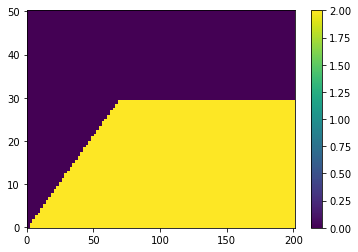

In [13]:
ag = ldr.load_agent_from_path(cps[3])
ww, ll, p, z = policy_pricer_python.create_map(ag, larger_offset=True, w_points = 100, l_points=100, lam_lim=50)

plt.pcolormesh(ww, ll, p, shading='auto')
plt.colorbar()
plt.show()

In [14]:
calc_checkpoint_value(portfolio, cps[0], niter=5000, w_points = 100, l_points=100, lam_lim=10)

(63.44428346573778, 26.52123880655197)

In [ ]:
vals = value_names(ldr, AGENTS, portfolio, file_name='DQN_DQNL_BSPLINES', n_jobs=1, log_num=0, niter=10000, w_points = 200, l_points=100, lam_lim=10)

  0%|                                                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]

Recomputing for a given portfolio:


In [38]:
LEARNING_STEPS = 50000
STEP_BY = 500
LEARNING_STEPS_CUTOFF = 49000

def process_plot_data(vals, key: str, cutoff: int):
    data_from_key = dqns = [ l for k,l in vals.items() if k.startswith(key)]
    avgs = np.zeros((cutoff, len(data_from_key)), dtype='float64')
    stds = np.zeros((cutoff, len(data_from_key)), dtype='float64')
    for i, teration in enumerate(data_from_key):
        avgs[:, i] = [data[0] for data in data_from_key[i][:cutoff]]
        stds[:, i] = [data[1] for data in data_from_key[i][:cutoff]]
    return avgs, stds

def plot_learning(names, vals, percentage=True, title=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.arange(0, LEARNING_STEPS_CUTOFF, STEP_BY)
    cutoff = LEARNING_STEPS_CUTOFF // STEP_BY
    a_s = AAV_VAL
    v_s = VOPT_VAL
    ds = []
    if percentage:
        mean_pfolio = np.mean(portfolio, axis=0)[1]
    for i, name in enumerate(names):
        avgs, stds = process_plot_data(vals, name, cutoff)
        if percentage:
            avgs = avgs/mean_pfolio * 100
            a_s = a_s / mean_pfolio * 100
            v_s = VOPT_VAL / mean_pfolio * 100
        stds = np.std(avgs, axis=1)
        avgs = np.mean(avgs, axis=1)
        ax.plot(x, avgs)
        ax.fill_between(x, avgs-stds, avgs+stds, alpha=0.2)
    ax.legend(names)
    ax.set_xlabel(['Learning steps'])
    ax.axhline(a_s, color='red', linestyle='--')
    ax.axhline(v_s, color='brown', linestyle='--')
    if percentage:
        ax.axhline(100, color='black', linestyle=':')
    if title is not None:
        ax.set_title(title)
    

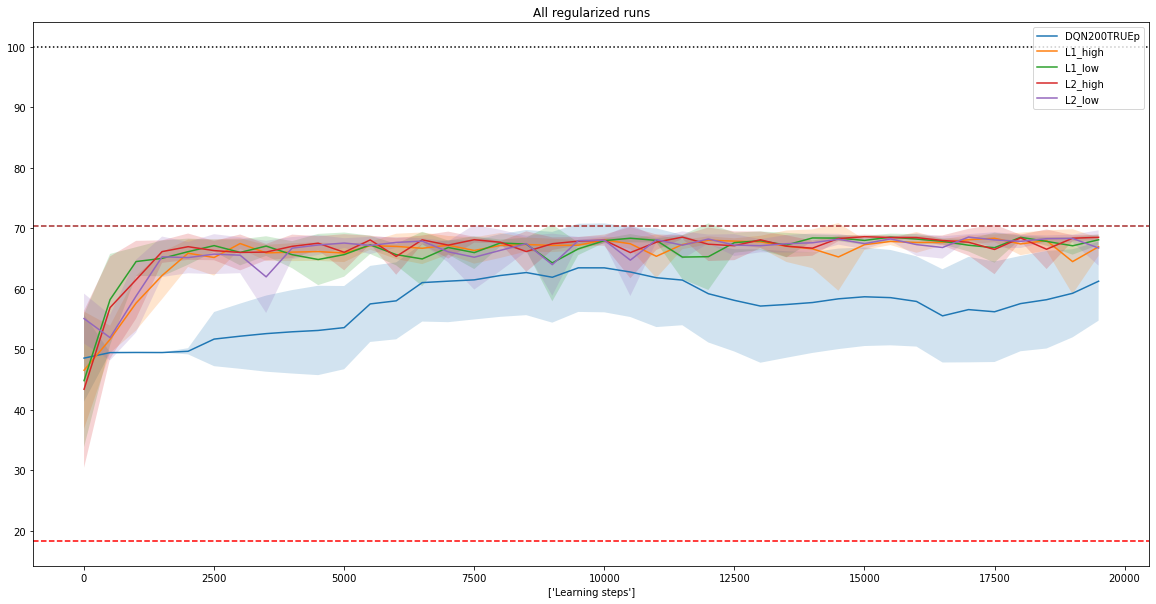

In [210]:
names_reuglarized = ['DQN200TRUEp','L1_high', 'L1_low', 'L2_high', 'L2_low']# , 'DQN-monotone-low', 'DQN-monotone-high']
plot_learning(names_reuglarized, combined_vals, LEARNING_STEPS_CUTOFF, title='All regularized runs')

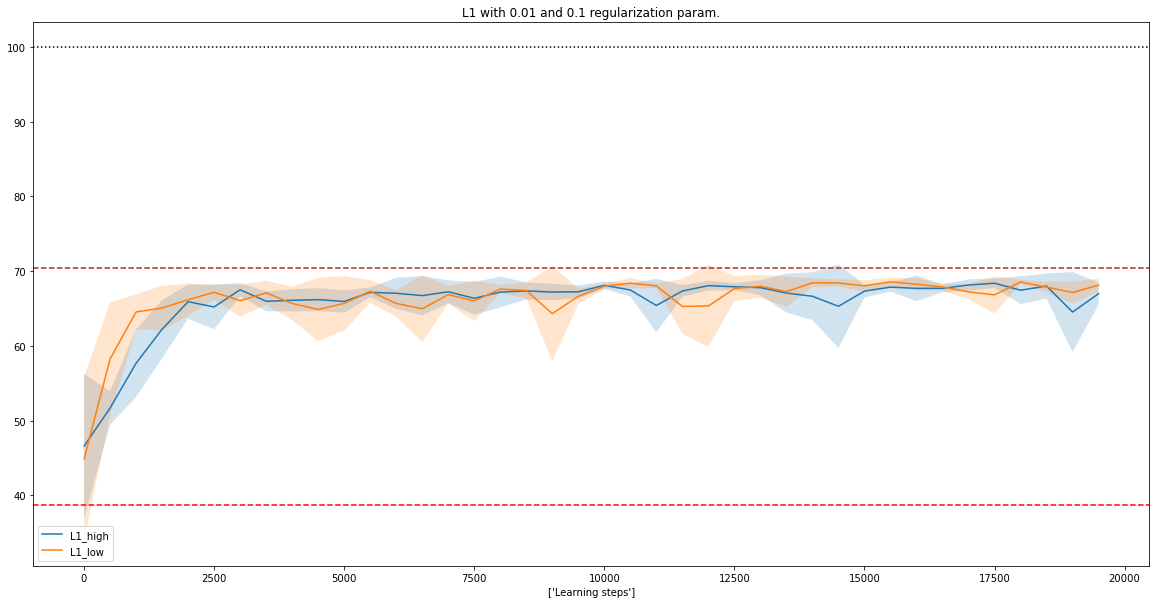

In [202]:
names_reuglarized = ['L1_high', 'L1_low']
plot_learning(names_reuglarized, vals, LEARNING_STEPS_CUTOFF, title='L1 with 0.01 and 0.1 regularization param.')

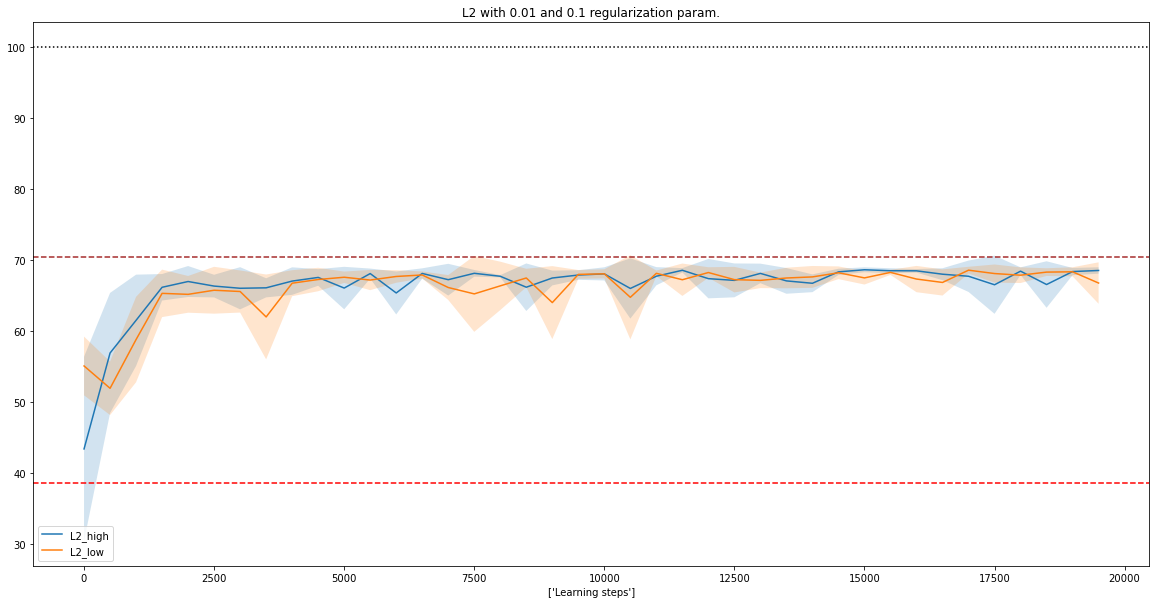

In [201]:
names_reuglarized = ['L2_high', 'L2_low']
plot_learning(names_reuglarized, vals, LEARNING_STEPS_CUTOFF, title='L2 with 0.01 and 0.1 regularization param.')

In [42]:
dqns = [ l for k,l in vals.items() if k.startswith('DQN200TRUEp')]
dqnl1_h = [ l for k,l in vals.items() if k.startswith('L1_high')]
dqnl1_l = [ l for k,l in vals.items() if k.startswith('L1_low')]
dqnl2_h = [ l for k,l in vals.items() if k.startswith('L2_high')]
dqnl2_l = [ l for k,l in vals.items() if k.startswith('L2_low')]

In [48]:
np.std([run[1][0] for run in dqns])

0.04127226737701819

Load Neural nets with reularizer:

In [79]:
monotone_models = ['DQN-monotone-high-' + str(i) for i in range(0, 5)] + ['DQN-monotone-low-' + str(i) for i in range(0, 5)]

In [81]:
# monotone_models

In [82]:
monotone_vals = value_names(ldr, monotone_models, portfolio, file_name='monotone_mc', n_jobs=45, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5)

  0%|                                                                                                          | 0/10 [00:00<?, ?it/s]

Recomputing for a given portfolio:


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [54:25<00:00, 326.53s/it]


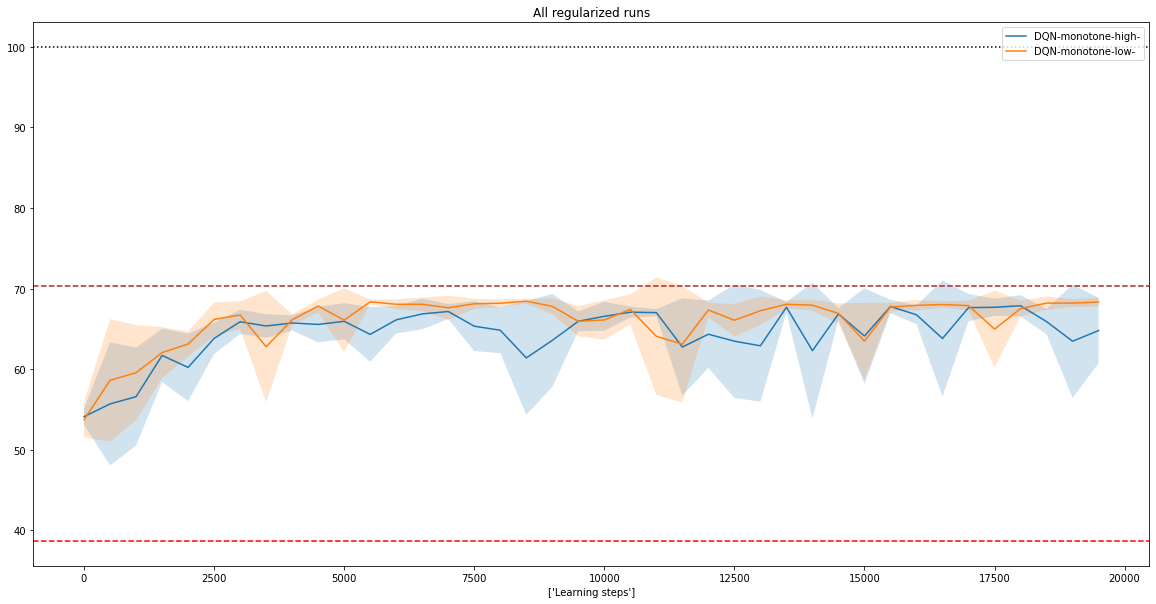

In [83]:
LEARNING_STEPS = 50000
STEP_BY = 500
LEARNING_STEPS_CUTOFF = 20000

plot_learning(['DQN-monotone-high-', 'DQN-monotone-low-'], monotone_vals, LEARNING_STEPS_CUTOFF, title='All regularized runs')

In [87]:
combined_vals = {**vals, **monotone_vals}

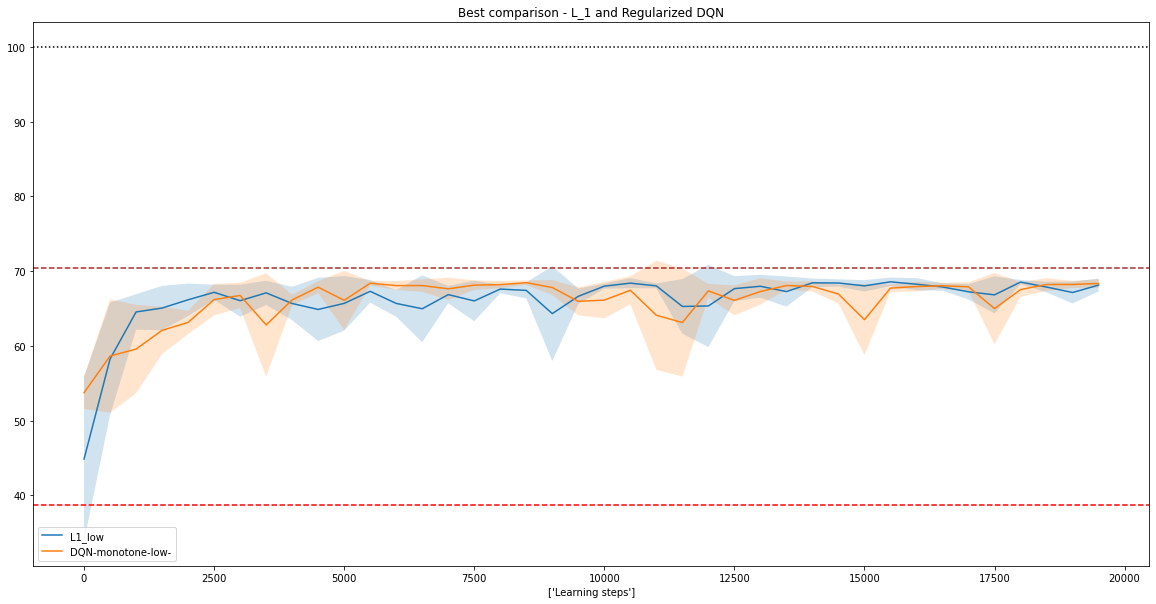

In [203]:
plot_learning(['L1_low', 'DQN-monotone-low-'], combined_vals, LEARNING_STEPS_CUTOFF, title='Best comparison - L_1 and Regularized DQN')

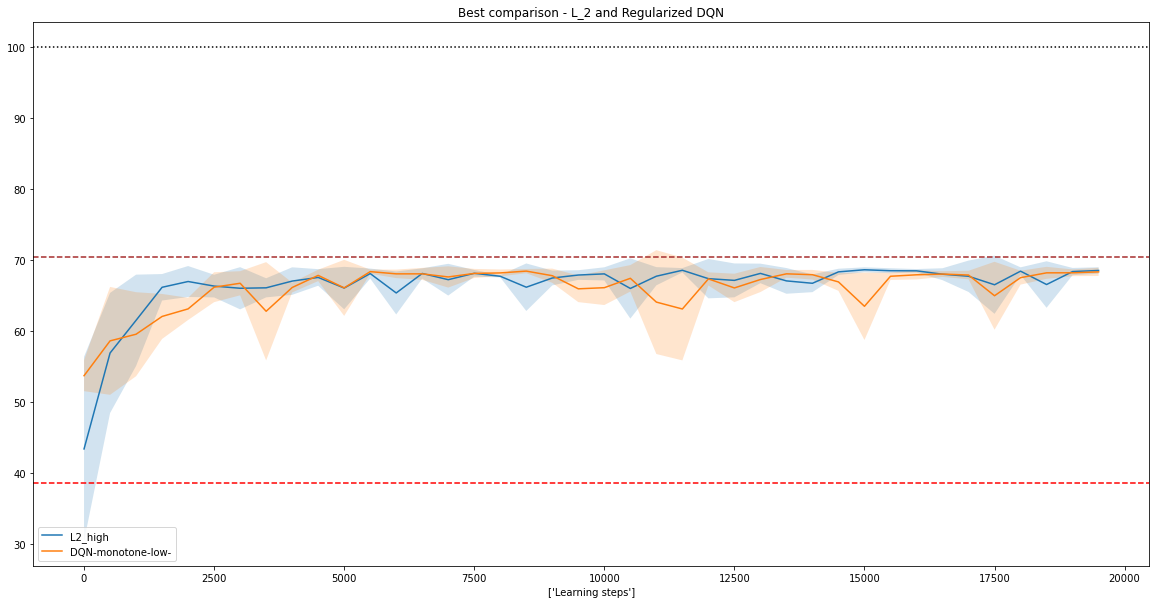

In [207]:
plot_learning(['L2_high', 'DQN-monotone-low-'], combined_vals, LEARNING_STEPS_CUTOFF, title='Best comparison - L_2 and Regularized DQN')

### Let's see how weights change in time

In [126]:
logging.getLogger().setLevel(logging.ERROR)

def calc_checkpoint_weights(checkpoint):
    model = tf.keras.models.load_model(os.path.join(checkpoint, 'main_net.h5'))
    sys.stdout.flush()
    return [weight.numpy() for weight in model.trainable_weights]

def w_calc_agent(ldr, name, log_num=0):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
    vals = []
    for i, path in enumerate(tqdm(checkpoint_paths)):
    # for i, path in enumerate(checkpoint_paths):
        vals.append(calc_checkpoint_weights(path))
    return vals


def w_calc_agent_parallel(ldr, name, n_jobs, log_num=0):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
#     vals = np.zeros(len(checkpoint_paths))
#     stds = np.zeros(len(checkpoint_paths))
    rets = Parallel(n_jobs=n_jobs)(delayed(calc_checkpoint_weights)(path) for path in checkpoint_paths)
    return rets

def weights_names(ldr, names, n_jobs=20, log_num=0):
    results = {}
    for i, name in enumerate(tqdm(names)):
        if n_jobs>1:
            results[name] =  w_calc_agent_parallel(ldr, name, log_num=0, n_jobs=n_jobs)
        else:
            results[name] = w_calc_agent(ldr, name, log_num=0)
    return results

In [179]:
cp = ldr.list_checkpoints('DQN-monotone-high-1', log_num=-1)[0]

# calc_checkpoint_value()
#ldr.load_agent_from_path(cp)
# os.listdir(cp)

In [184]:
os.path.join(cp, 'main_net.h5')

'C:\\Users\\mmark\\Documents\\Projects\\credit_collections_rl\\learning\\resources\\models\\DQN-monotone-high-1\\20210408-010702\\checkpoints\\0\\main_net.h5'

In [127]:
w_norms_dqn_l1_high = w_calc_agent(ldr, 'L1_high-1' , log_num=0)
w_norms_dqn_l1_low = w_calc_agent(ldr, 'L1_low-1' , log_num=0)
w_norms_dqn_l2_high = w_calc_agent(ldr, 'L2_high-1' , log_num=0)
w_norms_dqn_l2_low = w_calc_agent(ldr, 'L2_low-1' , log_num=0)
w_norms_dqn_monotone_high = w_calc_agent(ldr, 'DQN-monotone-low-0' , log_num=0)
w_norms_dqn_monotone_low = w_calc_agent(ldr, 'DQN-monotone-high-0' , log_num=0)
w_norms_dqn_200p = w_calc_agent(ldr, 'DQN200Truep' , log_num=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


In [174]:
def calculate_normed_differences(retrieved_norms):
    """
    Calculates the norm of the difference between consecutive weights. Takes into account only weights, no biases.
    """
    i = 1
    differences = []
    for i, weights_stack in enumerate(retrieved_norms[1:]):
        network_weights = [weight for weight in weights_stack if weight.ndim>1]
        network_weights_previous = [weight for weight in retrieved_norms[i-1] if weight.ndim>1]
        differences.append([np.linalg.norm(network_weights[j] - network_weights_previous[j]) for j,_ in enumerate(network_weights)])
    return np.sum(differences, axis=1)

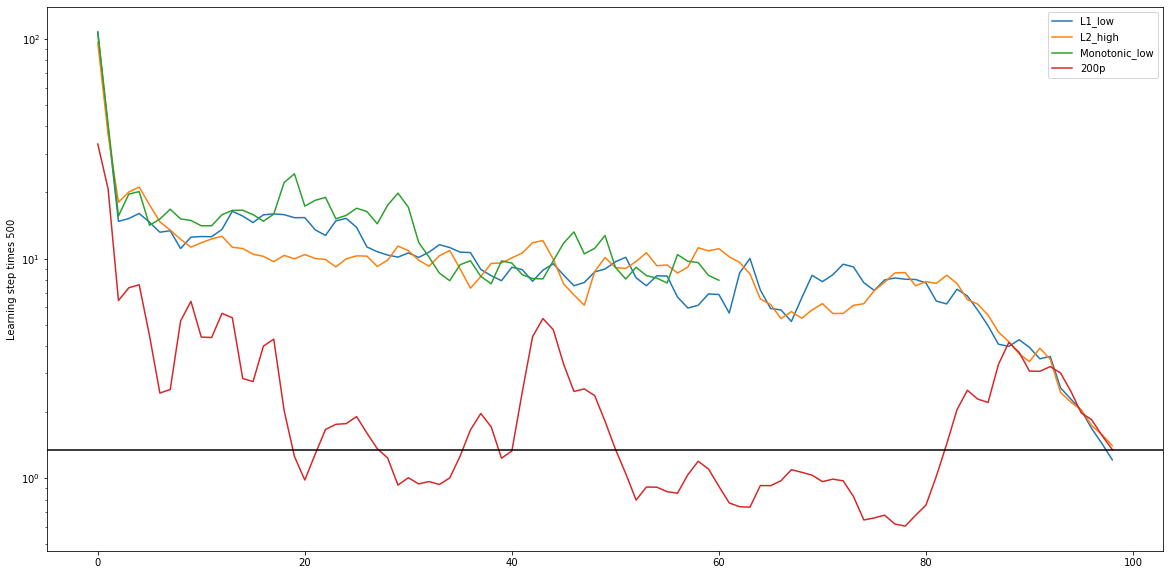

In [218]:
fig, ax = plt.subplots(figsize=(20,10))

#ax.plot(calculate_normed_differences(w_norms_dqn_l1_high))
ax.plot(calculate_normed_differences(w_norms_dqn_l1_low))
#ax.plot(calculate_normed_differences(w_norms_dqn_l2_high))
ax.plot(calculate_normed_differences(w_norms_dqn_l2_high))
#ax.plot(calculate_normed_differences(w_norms_dqn_monotone_high))
ax.plot(calculate_normed_differences(w_norms_dqn_monotone_low))
ax.plot(calculate_normed_differences(w_norms_dqn_200p))
ax.axhline(calculate_normed_differences(w_norms_dqn_200p)[-1], color='black')
ax.legend(['L1_low', 'L2_high', 'Monotonic_low', '200p'])
ax.set_ylabel(r'$\sum_{L=0}||w_i^L - w_{i-1}^L||_2$')
ax.set_ylabel(r'Learning step times 500')
ax.set_yscale('log')

#### THIS IS THE OLD EVALUATION METHOD

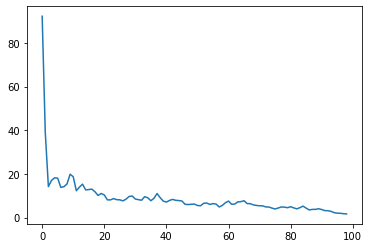

In [169]:
plt.plot(np.sum(differences, axis=1))

Text(0, 0.5, '$\\frac{||w_i||_2}{||w_50000||_2}$')

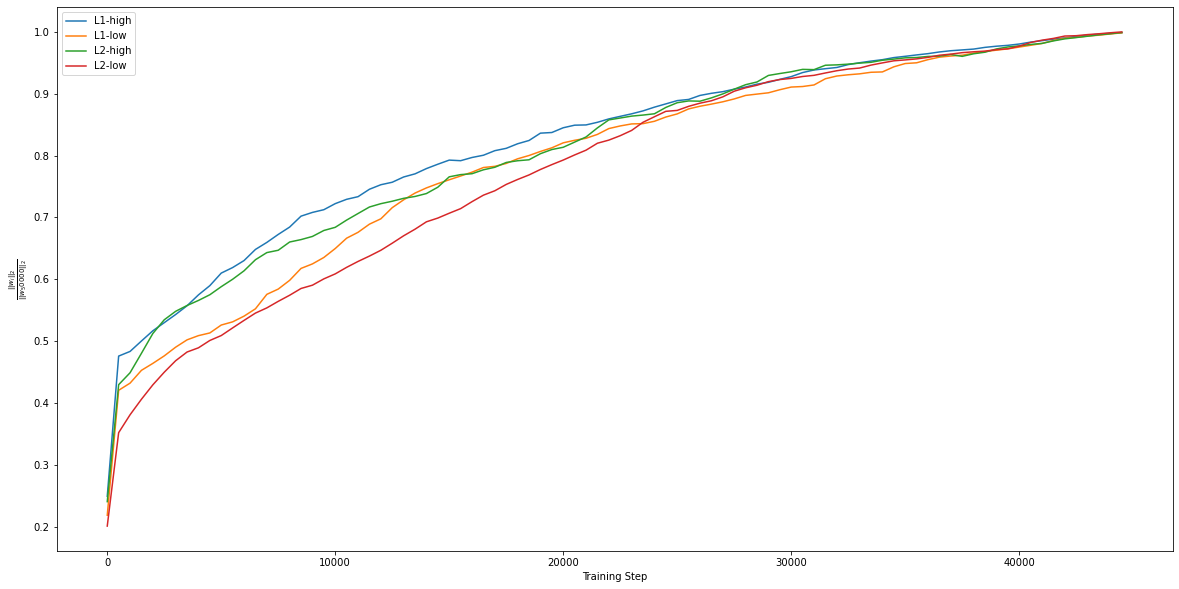

In [120]:
CUTOFF_LEARNING = 45000

fig, ax = plt.subplots(figsize=(20,10))
x = np.arange(0, CUTOFF_LEARNING, 500)

#x2 = np.linspace(0, CUTOFF_LEARNING, 99)
ax.plot(x, w_norms_dqn_l1_high[:len(x)] / w_norms_dqn_l1_high[len(x)])
ax.plot(x, w_norms_dqn_l1_low[:len(x)] / w_norms_dqn_l1_low[len(x)])
ax.plot(x, w_norms_dqn_l2_high[:len(x)] / w_norms_dqn_l2_high[len(x)])
ax.plot(x, w_norms_dqn_l2_low[:len(x)] / w_norms_dqn_l2_low[len(x)])
ax.legend(['L1-high', 'L1-low', 'L2-high', 'L2-low'])
ax.set_xlabel('Training Step')
ax.set_ylabel(r'$\frac{||w_i||_2}{||w_50000||_2}$')